In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt

# Physical constant
These are some physical parameters that define the behavior of the model we explore

In [36]:
A = 1
ρ_i = 917.0
ρ_a = 1.275
cp = 2050.0
L = 334000.0
K = 2.1
g = 9.806
γ = 0.07
dp = 10**-4
μ = 10**-3
Tm =273.15
C_i = 0.0013
L_v = 2.501e6
L_s = 2.834e6
c_a = 1005.0
ϵ_i = 1.0
σ = 5.67e-8
α_s = .8
α = 1; #% exponent of capillary pressure
β = 2; #% saturation flux exponent
nglen = 1

# Simluation parameters
These parameters define the nature of the simulation

In [50]:
T = 1 * 31536000
plot_amount = 1000
#% time between each plot
save_freq = 100
#% frequency at which plots are saved
phi0 = 0.64
#% surface porosity

#% Discretization % % % % % % % % % % % % % %
dx = .25
dt = 3600.0

a = 0
b = 100
N = int((b - a) / dx)
#% Number of grid cells
xcelledges = np.linspace(a, b, N + 1)  #% Cell edges
xgrid = (xcelledges[0:N] + xcelledges[1 : (N + 1)]) / 2
#% Cell centers

solver_type = 'empirical'

#% Time step information
Nt = int(T / dt)


In [51]:
df_T2m

,time,spatial_ref,t2m
0,2015-01-01 00:00:00,0,255.584290
1,2015-01-01 01:00:00,0,255.496316
2,2015-01-01 02:00:00,0,255.465765
3,2015-01-01 03:00:00,0,255.456955
4,2015-01-01 04:00:00,0,255.400956
...,...,...,...
8755,2015-12-31 19:00:00,0,254.289282
8756,2015-12-31 20:00:00,0,254.383160
8757,2015-12-31 21:00:00,0,254.436088
8758,2015-12-31 22:00:00,0,254.367186


# Surface energy flux

In [52]:
df_u10m = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-10m_u_component_of_wind-2015.csv')
df_v10m = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-10m_v_component_of_wind-2015.csv')
df_T2m = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-2m_temperature-2015.csv')
df_sw = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-mean_surface_downward_short_wave_radiation_flux-2015.csv')
df_lw = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-mean_surface_downward_long_wave_radiation_flux-2015.csv')
df_sf = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-snowfall-2015.csv')
df_sp = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-surface_pressure-2015.csv')
df_sh1000hPa = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-specific_humidity-2015.csv')
df_T1000hPa = pd.read_csv('/Volumes/ERA5/data/Pine_Island-iceshelf/era5-temperature-2015.csv')



In [53]:
df_T1000hPa

,time,spatial_ref,t
0,2015-01-01 00:00:00,0,259.690116
1,2015-01-01 01:00:00,0,259.602671
2,2015-01-01 02:00:00,0,259.708701
3,2015-01-01 03:00:00,0,259.750731
4,2015-01-01 04:00:00,0,259.698536
...,...,...,...
8755,2015-12-31 19:00:00,0,258.342219
8756,2015-12-31 20:00:00,0,258.417277
8757,2015-12-31 21:00:00,0,258.515622
8758,2015-12-31 22:00:00,0,258.287444


In [54]:
U = np.sqrt(df_u10m['u10'].values**2+df_v10m['v10'].values**2)
T2m = df_T2m['t2m'].values
sw = df_sw['msdwswrf'].values
lw = df_lw['msdwlwrf'].values
sf = df_sf['sf'].values
sp = df_sp['sp'].values
qa = df_sh1000hPa['q'].values
Ta = df_T1000hPa['t'].values

In [55]:
def pv(T):
    r"""
    calculate the

    """
    return 2.53e8*np.exp(-5420./T)

def qsat(T,P):
    r"""
    calculate the near surface specific humidity
    
    """
    return .622*pv(T)/(P - .378*pv(T))

def ustar(u,C,density):
    r"""
    calculate the friction velocity
    
    NOTE: likely overestimates ustar in the area covered case.
    """

    return u*np.sqrt((ρ_a/density)*C)


def sensible(T,T_a,u,C=C_i):
    r"""
    calculate the sensible heat flux
    
    """
    return ρ_a*c_a*C*u*(T-T_a)

def latent(T,P,q,u,C=C_i,L=L_v):
    r"""
    claculate the latent heat flux
    
    """
    return ρ_a*L*C*u*(qsat(T,P)-q)


def energy_balance(temperature_surface,temperature_ambient,Q_sw,Q_lw,u,P,q):
    r"""
    calculate ice surface energy balance
    
    """

    Q_sens = sensible(temperature_surface,temperature_ambient,u,C_i)
    Q_lat = latent(temperature_surface,P,q,u,C_i,L_s)

    return Q_sens + Q_lat + ϵ_i*σ*temperature_surface**4 - (1-α_s)*Q_sw - ϵ_i*Q_lw  


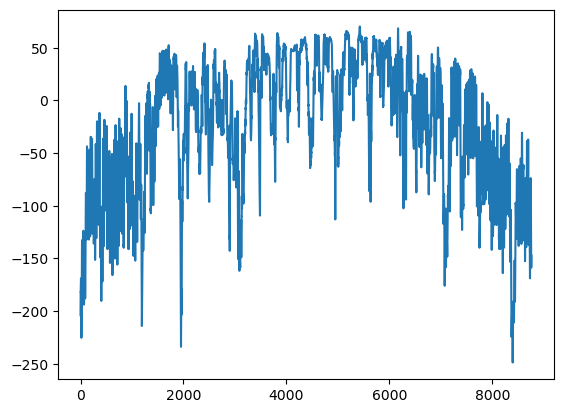

In [56]:
plt.subplots()
plt.plot(energy_balance(T2m,T2m,sw,lw,U,sp,qa))

# Model variables

In [57]:
phiwithz = np.zeros((N, int(Nt / save_freq + 2)))
Swithz = np.zeros((N, int(Nt / save_freq + 2)))
Thetawithz = np.zeros((N, int(Nt / save_freq + 2)))
MeltRateSave = np.zeros((int(Nt / save_freq + 2)))
RunOffSave = np.zeros((int(Nt / save_freq + 2)))
time = np.zeros((int(Nt / save_freq) + 2))
SIV = np.zeros((int(Nt / save_freq + 2)))
BIV = np.zeros((int(Nt / save_freq + 2)))
BottomIceFlux = np.zeros((int(Nt / save_freq + 2)))
IceFlux = np.zeros((int(Nt / save_freq + 2)))
WaterFlux = np.zeros((int(Nt / save_freq + 2)))
BottomWaterFlux = np.zeros((int(Nt / save_freq + 2)))
TotalFlux = np.zeros((int(Nt / save_freq + 2)))

#% Initialize variables
Tsurf = np.zeros(Nt)
MeltRate = np.zeros(Nt)
RunOff = np.zeros(Nt)
RO = np.zeros(Nt)
LiquidWater = np.zeros(Nt)
TotalIce = np.zeros(Nt)

In [58]:
#% Functions
def k(p):
    return dp**2 / 180* p ** 3


def kr(s, β=β):
    return s ** β


def pc(s, α=α):
    return γ / dp * s ** (-α)


def kr_pc_prime(s, α=α, β=β):
    return -α * γ / dp * (s ** (β - (α + 1)))

# Initialize parameters

In [59]:
Rbar = 0
#% fixed surface water flux (rain)
pressure0 = -(pc(1.0) * γ / dp) * np.ones(N)
#% initial pressure
zs = 0
#% zero initial surface height
W = (1 - phi0) * np.ones(N) # initially saturation is zero.
#% take in W from above


H = W * energy_balance(T2m[0],T2m[0],sw[0],lw[0],U[0],sp[0],qa[0])

In [78]:
def solve_matrix(A,b):
    num_vars = A.shape[1]
    rank = np.linalg.matrix_rank(A)
    print(rank)
    if rank == num_vars:              
        sol = np.linalg.lstsq(A, b)[0]    # not under-determined
    else:
        for nz in combinations(range(num_vars), rank):    # the variables not set to zero
            try: 
                sol = np.zeros((num_vars, 1))  
                sol[nz, :] = np.asarray(np.linalg.solve(A[:, nz], b))
                print(sol)
            except np.linalg.LinAlgError:     
                pass     
    return sol


def sparse_compress(i, j, v, m, n):
    """
    Create and compressing a matrix that have many zeros
    Parameters:
        i: 1-D array representing the index 1 values 
            Size n1
        j: 1-D array representing the index 2 values 
            Size n1
        v: 1-D array representing the values 
            Size n1
        m: integer representing x size of the matrix >= n1
        n: integer representing y size of the matrix >= n1
    Returns:
        s: 2-D array
            Matrix full of zeros excepting values v at indexes i, j
    """
    return sparse.csr_matrix((v, (i, j)), shape=(m, n)).toarray()

def conversiontotemperature(H,W):
    #% This function takes in the enthalpy and total water/ice mass and spits
    #% out the temperature, porosity, and saturation
    #% [T,phi,S] = conversiontotemperature(H,W,Stefan)
    T = np.minimum(0.0,(H/W));
    phi = np.maximum(1 - W + np.maximum(0.0,H/(ρ_i*L)),0.0);
    #% Sc = max(0,(H./(Stefan*phi)));
    #% S = max(0,H)./(max(0,H)+Stefan*(1-W));
    S = np.maximum(np.minimum(1,np.maximum(0,H/(ρ_i*L*phi))),0);
    #S = np.maximum(np.minimum(1,np.maximum(0.0,H))/(np.maximum(0,H))+Stefan*(1-W),0.0);
    return T,phi,S

def conversiontoenthalpy(T,phi,S):
    #% This function takes in the enthalpy and total water/ice mass and spits
    #% out the temperature, porosity, and saturation
    #% [T,phi,S] = conversiontotemperature(H,W,Stefan)
    W = 1 - phi + phi * S;
    H = ρ * cp * W * (T) + ρ * L * phi * S;
    return H,W

def temperaturediffusiveflux(TotalWater,Temperature,dt,dx,Constants):
    #% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    #% [Fp,Fm] = TemperatureDiffusiveFlux(TotalWater,Temperature,dt,dx,Constants)
    #% Diffusive flux with input arguments: TotalWater which is W and 
    #% temperature, which comes from the function
    #% [T,phi,S]=conversiontotemperature(H,W,Stefan).
    #% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    Temperaturem = np.append(Temperature[0],Temperature[0:-1])
    Temperaturep = np.append(Temperature[1:], Temperature[-1])

    TotalWaterm = np.append(TotalWater[0], TotalWater[0:-1])
    TotalWaterp = np.append(TotalWater[1:], TotalWater[-1])

    Dm = TotalWaterm;
    D = TotalWater;
    Dp = TotalWaterp;

    fim = (2/dx)*(((1./Dm)+(1./D))**(-1));
    fip = (2/dx)*(((1./D)+(1./Dp))**(-1));
    Fm = -Constants*fim*(Temperature-Temperaturem);
    Fp = -Constants*fip*(Temperaturep-Temperature);
    return Fp,Fm 

def saturationdiffusiveflux(Porosity,Saturation,dt,dx):
    #% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    #% [Fp,Fm] = SaturationDiffusiveFlux(Diffusivity,Porosity,Saturation,dt,dx,Constants)
    #% Diffusive flux with input arguments: Diffusivity as a function handle of
    #% phi and S (two input arguments) and Porosity and
    #% Saturation, which come from the function
    #% [T,phi,S]=conversiontotemperature(H,W,Stefan).
    #% Constants are U/B
    #% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %

    Porositym = np.append(Porosity[0],Porosity[0:-1]);
    Porosityp = np.append(Porosity[1:], Porosity[-1]);

    #print(len(Porosity))
    #print(len(Porositym))
    #print(len(Porosityp))
    Saturationm = np.append(Saturation[0], Saturation[0:-1]);
    Saturationp = np.append(Saturation[1:], Saturation[-1]);

    Dm = k(Porositym)*kr_pc_prime(Saturationm);
    D = k(Porosity)*kr_pc_prime(Saturation);
    Dp = k(Porosityp)*kr_pc_prime(Saturationp);

    fim = (2/dx)*(((1./Dm)+(1./D))**(-1));
    fip = (2/dx)*(((1./D)+(1./Dp))**(-1));
    Fm = ρ_i * g / μ * γ / dp *fim*(Saturation-Saturationm);
    Fp = ρ_i * g / μ * γ / dp *fip*(Saturationp-Saturation);

    return Fp,Fm

def fullysaturatedwaterpressure(U,pressure,dx,xgrid,N,A,phi,W,Theta,nglen,Indicator,Accumulation,solver_type):
    # % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    # Compute water pressure when the snowpack is fully saturated. I is an
    # indicator function that determines whether to solve for the water pressure
    # % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    phimin = 10**(-4);
    Indicator[phi<phimin]=0;
    phim = np.append(phi[0], phi[0:-1]); #% cell values to the left of cell i
    phip = np.append(phi[1:], phi[-1]); #% cell values to the right of cell i
    Dm = 1 / μ * k(phim);
    D = 1 / μ * k(phi);
    Dp = 1 / μ * k(phip);
    fim = (2/dx)*(((1/Dm)+(1/D))**(-1));
    fip = (2/dx)*(((1/D)+(1/Dp))**(-1));
    fip[N-1]=0; #% no pressure gradient
    # full difference
    S = np.append(np.append(fim[1:].conj().T, -(fim+fip).conj().T),fip[0:-1].conj().T);
    Ind = np.append(np.append(np.arange(1,N), np.arange(0,N)), np.arange(0,(N-1)));
    Jnd = np.append(np.append(np.arange(0,(N-1)), np.arange(0,N)), np.arange(1,N));

    #print(len(N))
    M = sparse_compress(Ind,Jnd,S,N,N);
    # positive flux
    S = np.append(np.append(np.zeros(N-1),-fip.conj().T),fip[0:-1].conj().T);
    Ind = np.append(np.append(np.arange(1,N), np.arange(0,N)), np.arange(0,(N-1)));
    Jnd = np.append(np.append(np.arange(0,(N-1)), np.arange(0,N)), np.arange(1,N));


    Mp = sparse_compress(Ind,Jnd,S,N,N);
    # negative flux
    S = np.append(np.append(-fim[1:].conj().T,fim.conj().T),np.zeros(N-1));
    Ind = np.append(np.append(np.arange(1,N), np.arange(0,N)), np.arange(0,(N-1)));
    Jnd = np.append(np.append(np.arange(0,(N-1)), np.arange(0,N)), np.arange(1,N));

    Mm = sparse_compress(Ind,Jnd,S,N,N);

    # compaction right hand side
    Shear = compactionfunction(xgrid,W,phi,Theta,A,nglen,Accumulation,solver_type);

    # saturation advection components
    SaturationVelocity = np.ones(N+1);
    [fadvSp,fadvSm] = advectiveflux(N,SaturationVelocity,ρ * g / μ *k(phi));
    fdifS = fadvSp-fadvSm;

    # water pressure computation


    #print((dx*Shear[Indicator]-fdifS[Indicator]+np.dot(M[Indicator][:,~Indicator],pressure[~Indicator])))
    indicatorX,indicatorY=np.meshgrid(Indicator,Indicator)
    indicatorXtilda,indicatorYtilda=np.meshgrid(~Indicator,~Indicator)
    #print(np.array(np.expand_dims(-M[Indicator,Indicator],axis=0)))
    #print(solve_matrix(np.expand_dims(-M[Indicator,Indicator],axis=0), dx*Shear[Indicator]-fdifS[Indicator]+np.dot(M[Indicator][:,~Indicator],pressure[~Indicator])).shape)
    #pressure[Indicator]= np.linalg.solve(((-M[Indicator,Indicator]).T.dot(-M[Indicator,Indicator])), (-M[Indicator,Indicator]).T.dot(dx*Shear[Indicator]-fdifS[Indicator]+M[Indicator,~Indicator]*pressure[~Indicator]));
    pressure[Indicator]= solve_matrix(-M[indicatorX*indicatorY].reshape(Indicator.sum(),Indicator.sum()), dx*Shear[Indicator]-fdifS[Indicator]+np.dot(M[indicatorY*indicatorXtilda].reshape(Indicator.sum(),~Indicator.sum()),pressure[~Indicator]))[0];

    fpD = -Mp*pressure; fmD = -Mm*pressure;
    qp = fpD+fadvSp;
    qm = fmD+fadvSm;
    return qp[0],qm[0],pressure

def enthalpydiffusiveflux(Temperature,Porosity,Saturation,dt,dx,Constants):
    #[Fp,Fm] = EnthalpyDiffusiveFlux(Diffusivity,Temperature,Porosity,Saturation,dt,dx,Constants,Stefan)
    #Diffusive flux with input arguments: Diffusivity as a function handle of
    #phi and S (two input arguments) and temperature, porosity, and
    #Saturation, come from the function
    # [T,phi,S]=conversiontotemperature(H,W,Stefan).
    # % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %
    # Here the diffusivity includes the (T+Stefan) term.
    # % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % %%
    
    #% Temperaturem = [Temperature(end); Temperature(1:(end-1))];
    #% Temperaturep = [Temperature(2:end); Temperature(1)];
    #% Porositym = [Porosity(end); Porosity(1:(end-1))];
    #% Porosityp = [Porosity(2:end); Porosity(1)];
    #% Saturationm = [Saturation(end); Saturation(1:(end-1))];
    #% Saturationp = [Saturation(2:end); Saturation(1)];
    Temperaturem = np.append(Temperature[0], Temperature[0:-1]);
    Temperaturep = np.append(Temperature[1:], Temperature[-1])
    Porositym = np.append(Porosity[0], Porosity[0:-1]);
    Porosityp = np.append(Porosity[1:], Porosity[-1]);
    Saturationm = np.append(Saturation[0], Saturation[0:-1]);
    Saturationp = np.append(Saturation[1:], Saturation[-1]);
    Dm = k(Porositym)*kr_pc_prime(Saturationm)*(Temperaturem+Stefan);
    D = k(Porosity)*kr_pc_prime(Saturation)*(Temperature+Stefan);
    Dp = k(Porosityp)*kr_pc_prime(Saturationp)*(Temperaturep+Stefan);
    fim = (2/dx)*(((1./Dm)+(1./D))**(-1));
    fip = (2/dx)*(((1./D)+(1./Dp))**(-1));
    Fm = Constants*fim*(Saturation-Saturationm);
    Fp = Constants*fip*(Saturationp-Saturation);
    return Fp,Fm

def compactionfunction(xgrid,W,phi,Theta,nglen,Accumulation,solver_type):
# This function takes in W, phi, and theta and outputs the compaction rate
# xcelledges are the cell edge values
# phi is the snow porosity
# W is the total water, i.e. sum of ice and liquid water
# Theta is the snow temperature
# A is the snow viscosity softness
# nglen is the snow viscosity exponent
    if solver_type=='none':
        Shear = np.zeros(len(phi)); # dw/dz
        
    elif solver_type=='poreclosure':
        IcePressure = integrate.cumtrapz(W,xgrid);
        Shear = 2.*(phi/(1-phi))*IcePressure**nglen; # dw/dz
        
    else:
        rhoi = 917; # ice density
        rhow = 1000; # water density
        f = 1-(550/rhoi); # transition porosity
        R = 8.314; # gas constant
        E0 = 10160; # activation energy
        E1 = 21400; # activation energy
        T = 273.15+Theta; # temperature in kelvin
        omega = 1/(3600*24*365); # 1/(seconds in a year)
        #ell = 200/(omega*917*334000); # lengthscale
        k0 = 11; # H&L1980 constant
        k1 = 575; # H&L1980 constant
        A0 = (rhoi/rhow)*Accumulation; # water equivalent accumulation per year % % ACCUMULATION TO MASS RATE
        A1 = (rhoi/rhow)*Accumulation; # water equivalent accumulation per year % % ACCUMULATION TO MASS RATE
        a = 1; # H&L1980 constant
        b = 1/2; # H&L1980 constant
        c0 = (k0*(A0**a))*np.exp(-E0/(R*T));
        c1 = (k1*(A1**b))*np.exp(-E1/(R*T));
        C = c0*(phi>=f)+c1*(phi<f);
        Shear = C*(phi/(1-phi)); # dw/dz
    return Shear

def advectiveflux(N,velocity,field):
    #% velocity is (N+1)x1
    #% field is Nx1
    fadv = np.zeros(N+1);
    for i in range(0,N+1):
        if (velocity[i]>0) and (i==0):
            #% fadv(i) = 0; # will be fixed by the boundary condition
            fadv[i] = velocity[i]*field[i]; # will usually be fixed by the boundary condition
        elif (velocity[i]>0) and (i!=0):
        	fadv[i] = velocity[i]*field[i-1];
        elif (velocity[i]<=0) and (i==(N)):
            #% fadv[i] = 0; # will be fixed by the boundary condition
            fadv[i] = velocity[i]*field[i-1]; # natural inflow
        elif (velocity[i]<=0) and (i!=(N)): # i.e velocity(i)<=0 and not at the end point
            fadv[i] = velocity[i]*field[i];
    fadvp = fadv[1:(N+1)];
    fadvm = fadv[0:N];
    return fadvp,fadvm


In [83]:
for n in [0]:  # range(Nt):
    #% assign values from previous timestep
    print("timestamp is: " + str(n * dt))
    W_nm1 = W
    H_nm1 = H
    # print(H)
    #% convert to Theta, phi, and S
    Theta_nm1, phi_nm1, S_nm1 = conversiontotemperature(H_nm1, W_nm1)
    #% % Theta is temperature % phi is porosity % S is saturation % %
    # print(S_nm1)
    #% Compute Compaction Velocity
    # print(phi_nm1)
    # print(W_nm1)
    # print(Theta_nm1)
    Shear = compactionfunction(
        xgrid, W_nm1, phi_nm1, Theta_nm1, nglen, sf[n], solver_type
    )
    CompactionVelocity = integrate.cumtrapz(
        np.append(Shear, Shear[-1]), xcelledges, initial=0
    )
    SurfaceIceVelocity = (sf[n] / (1 - phi0)) - MeltRate[np.maximum(n - 1, 0)]
    if SurfaceIceVelocity < 0:
        SurfaceIceVelocity = (sf[n] / (1 - phi_nm1[0])) - MeltRate[
            np.maximum(n - 1, 0)
        ]

    IceVelocity = SurfaceIceVelocity * np.ones(N + 1) - CompactionVelocity
    FadvIpW, FadvImW = advectiveflux(N, IceVelocity, W_nm1)
    #% Saturation Advective flux;
    SaturationVelocity = np.ones(N + 1)
    fadvSp, fadvSm = advectiveflux(N, SaturationVelocity, k(phi_nm1) * kr(S_nm1))
    FadvSp = ρ_i * g / μ * fadvSp
    FadvSm = ρ_i * g / μ * fadvSm

    #% Diffusive flux
    FpD, FmD = saturationdiffusiveflux(phi_nm1, S_nm1, dt, dx)

    #% No diffusive flux boundary condition
    FpD[-1] = 0

    #% Total water saturation flux
    FpWS = FadvSp + FpD
    FmWS = FadvSm + FmD

    #% Total fluxes
    FpW = FadvIpW + FpWS
    FmW = FadvImW + FmWS
    FmW[0] = sf[n] + Rbar
    # % accumulation and rain :: - RO[np.max(n-1,1)]
    Fdif = FpW - FmW
    W = W_nm1 - (dt / dx) * Fdif

    #% % Enthalpy % %
    #% Ice Advective flux;
    FadvIpH, FadvImH = advectiveflux(N, IceVelocity, H_nm1)

    #% Saturation Advective flux;
    SaturationVelocity = np.ones(N + 1)
    fadvSp, fadvSm = advectiveflux(N, SaturationVelocity, k(phi_nm1) * kr(S_nm1))
    FadvSp = ρ_i * g / μ * ρ_i * L * fadvSp
    FadvSm = ρ_i * g / μ * ρ_i * L * fadvSm
    # print(phi_nm1)
    # print(S_nm1)
    # print(k(phi_nm1)*kr(S_nm1))
    # print(FadvSp)
    # print(FadvSm)
    #% Enthalpy/Saturation Diffusive flux
    FpE, FmE = enthalpydiffusiveflux(Theta_nm1, phi_nm1, S_nm1, dt, dx, ρ_i * L)

    #% Temperature Diffusive flux
    FpT, FmT = temperaturediffusiveflux((1.0-phi_nm1), Theta_nm1, dt, dx, K)

    #% No diffusive flux boundary condition
    FpT[-1] = 0
    FpE[-1] = 0

    #% Total saturation flux
    FpS = FpE + FadvSp
    FmS = FmE + FadvSm

    #% Total Saturation and Temperature fluxes
    Fp = FadvIpH + FpS + FpT
    Fm = FadvImH + FmS + FmT
    # print(EbarFun(n*dt))
    Fm[0] = Q - h*Theta_nm1 + ρ*L*R - ρ*L*r#Stefan * (EbarFun(n * dt) - Theta_nm1[0]) + Stefan * Rbar
    # % Enthalpy neumann conditions
    Fdif = Fp - Fm
    H = H_nm1 - (dt / dx) * Fdif

timestamp is: 0.0


TypeError: enthalpydiffusiveflux() missing 1 required positional argument: 'Stefan'

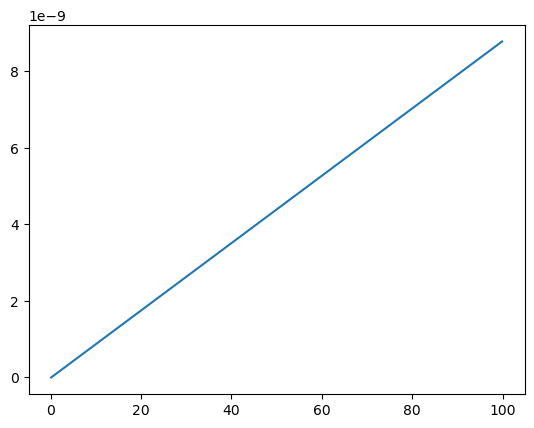

In [70]:
plt.subplots()
plt.plot(xgrid,CompactionVelocity[:-1])